# **CNN(Convolutional neural networks)**
CV는 일반 분류와 달리 특정 물체를 찾을때 특정 __패턴__ 과 조합을 찾기위해 이미지를 스캔해야 한다.   
**즉, 이미지의 정확한 이미지가 아닌 특정 패턴의 상대적인 위치와 존재가 중요하다**   
그리고 이 패턴을 추출하기 위해 __CNN__ 개념을 사용한다.

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

D:\download\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### **컨볼루션 필터**
컨볼류션 필터는 이미지의 각 픽셀에 걸쳐 실행되고 인접 픽셀의 가중 평균을 계산하는 작은 창으로 가중치 계수 행렬로 정의된다.

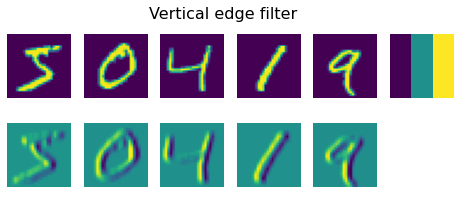

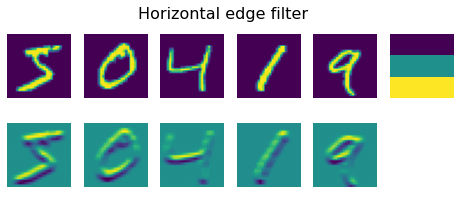

In [2]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

### **Covolutional 레이어**
컨벌루션 레이어는 `nn.Conv2d` 구성을 사용하여 정의된다.
* `in_channels` : 입력 채널 수
* `out_channels` : 사용할 필터 수
* `kernel_size` : 슬라이딩 창의 크기

In [4]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=(5, 5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184, 10)
    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x
net = OneConv()
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

Epoch  0, Train acc=0.943, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.978, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.985, Val acc=0.974, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.986, Val acc=0.975, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.975, Train loss=0.000, Val loss=0.001


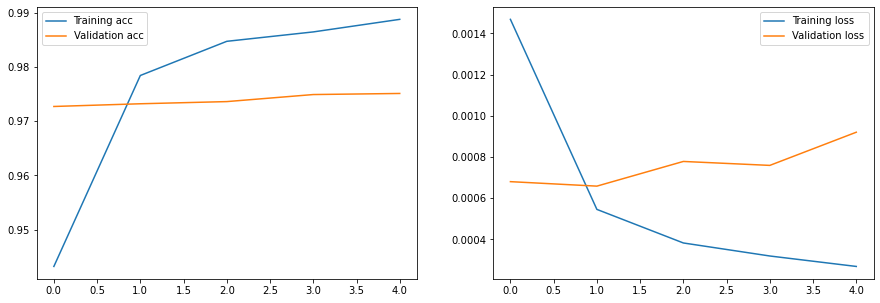

In [5]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

### **다중 계층 CNN 및 풀링 계층**

In [7]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320, 10)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x), dim=1)
        return x
net = MultiLayerCNN()
summary(net, input_size=(1,1,28,28))

D:\download\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

### **CIFAR-10 데이터 세트의 실제 이미지로 재생**
다양한 물체의 그림에 대한 고급 데이터 세트 살펴보기

In [10]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'hourse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


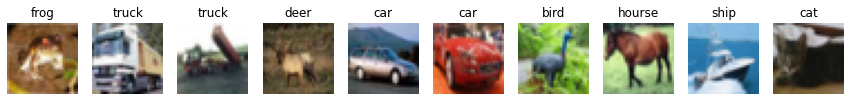

In [11]:
display_dataset(trainset, classes=classes)

In [12]:
# 모델을 더 단순화 한다. `log_softmax` 출력 활성화 함수로 사용하지 않고 마지막 완전 연결 레이어의 출력만 반환한다.
# 이경우 `CrossEntropyLoss` 손실 함수를 사용하여 모델을 최적화 할 수 있다.
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 120, 5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = LeNet()
summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

In [ ]:
# 학습 - 오래걸림
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())